In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans

sns.set_context(context='notebook')

In [2]:
import xgboost as xgb

In [3]:
class OOFCallback:
    def  __init__(self, oof_preds_dict, maximize=True):
        """
        :param dict oof_preds_dict: Should be an empty dict which can later be
            retrieved.
        :param bool maximize: If True, higher metric scores treated as better.
        """
        self.best_eval_metric = None
        self.oof_preds_dict = oof_preds_dict
        self.maximize=maximize

    def __call__(self, cbenv):
        current_val_score = cbenv.evaluation_result_list[1][1]
        if self.best_eval_metric is None:
            self.best_eval_metric = current_val_score
        if self.maximize:
            if current_val_score >= self.best_eval_metric:
                self.best_eval_metric = current_val_score
                self._compute_oof_preds(cbenv.cvfolds)
        elif current_val_score <= self.best_eval_metric:
                self.best_eval_metric = current_val_score
                self._compute_oof_preds(cbenv.cvfolds)

    def _compute_oof_preds(self, cvfolds):
        for i, fold in enumerate(cvfolds):
            self.oof_preds_dict[i] = fold.bst.predict(fold.dtest)

In [4]:
train = pd.read_csv('../data/train.csv')

In [5]:
def make_dicts(df):
    f_dicts ={}
    
    features_dict = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        for y in ['cat', 'bin', 'con']:
            features_dict[x+'_'+y] =[]
            for i in df.columns.tolist()[2:]:
                j = i.split('_')
                if len(j) == 3:
                    j.append('con')
                if j[1]==x and j[3]==y:
                    features_dict[x+'_'+y].append(i)
    f_dicts['combo'] = features_dict
    
    features_dict_data_type = {}
    for y in ['cat', 'bin', 'con']:
        features_dict_data_type[y]=[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if len(j) == 3:
                j.append('con')
            if j[3]==y:
                features_dict_data_type[y].append(i)
    f_dicts['type'] = features_dict_data_type
    
    features_dict_data_label = {}
    for x in ['ind', 'reg', 'car', 'calc']:
        features_dict_data_label[x] =[]
        for i in df.columns.tolist()[2:]:
            j = i.split('_')
            if j[1]==x:
                features_dict_data_label[x].append(i)
    f_dicts['label'] = features_dict_data_label
    return f_dicts
f_dicts = make_dicts(train)

In [6]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [7]:
train = (pd.read_csv('../data/train.csv', na_values=-1)
           .fillna(value=999))
            
test  = (pd.read_csv('../data/test.csv', na_values=-1)
           .fillna(value=999)) 
targets = train.target.values

In [8]:
def prepare_data():
    #non_imp = ['ps_ind_16_bin','ps_car_08_cat','ps_car_11_cat','ps_ind_06_bin','ps_ind_12_bin','ps_ind_13_bin','ps_car_02_cat','ps_ind_07_bin','ps_ind_09_bin','ps_ind_08_bin','ps_ind_14','ps_ind_18_bin','ps_car_10_cat','ps_ind_11_bin','ps_ind_10_bin']
    
    train = (pd.read_csv('../data/train.csv', na_values=999)
              .fillna(value=999))
    #unwanted = list((set(train.columns[train.columns.str.startswith('ps_calc_')])|set(non_imp)))
    #unwanted = ['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin','ps_car_10_cat','ps_ind_14','ps_car_11_cat',
    #           'ps_car_02_cat','ps_car_08_cat','ps_ind_18_bin','ps_ind_08_bin','ps_calc_15_bin','ps_calc_20_bin']
    unwanted =  ['ps_calc_19_bin',
                 'ps_car_10_cat',
                 'ps_ind_11_bin',
                 'ps_calc_06',
                 'ps_calc_08',
                 'ps_calc_13',
                 'ps_calc_11',
                 'ps_calc_07',
                 'ps_calc_18_bin',
                 'ps_calc_04',
                 'ps_calc_14',
                 'ps_calc_01',
                 'ps_calc_17_bin',
                 'ps_calc_09',
                 'ps_calc_02',
                 'ps_ind_13_bin',
                 'ps_ind_18_bin',
                 'ps_calc_16_bin',
                 'ps_ind_09_bin',
                 'ps_calc_03',
                 'ps_ind_10_bin',
                 'ps_calc_05',
                 'ps_ind_14',
                 'ps_calc_15_bin',
                 'ps_ind_12_bin',
                 'ps_calc_12',
                 'ps_calc_10',
                 'ps_calc_20_bin']
    train.drop(unwanted, axis=1, inplace=True)
            
    test  = (pd.read_csv('../data/test.csv', na_values=999)
              .fillna(value=999)
              .drop(unwanted, axis=1)) 
    
    y = train.target.values        
    train = train.drop(['id', 'target'], axis=1)
    
    test_id = test.id.values
    test = test.drop('id', axis=1)
    
    ## interactions:
    interaction_features = ['ps_car_13', 'ps_reg_03', 'ps_car_14','ps_ind_03']
    feature_combintation  = list(combinations(interaction_features, 2))
    for first_feature, second_feature in feature_combintation:
        new_name  = first_feature+'_'+second_feature+'comb'
        train[new_name] = train[first_feature].values*train[second_feature].values
        test[new_name] = test[first_feature].values*test[second_feature].values

    fl = train.columns.tolist()
    
    return train.values, y, test.values, test_id, fl

In [9]:
def prepare_data(features_selection ='all'):
    train = (pd.read_csv('../data/train.csv', na_values=-1)
           .fillna(value=999))
            
    test  = (pd.read_csv('../data/test.csv', na_values=-1)
               .fillna(value=999)) 
    test_id = test.id
    y = train.target.values
    train = train.drop(['id','target'], axis=1)

    features = train.columns
    
    features_bin = [i for i in features if set(i)&set('bin')==set('bin')]
    features_cat = [i for i in features if set(i)&set('cat')==set('cat')]
    features_con = list(set(features) - (set(features_bin)|set(features_cat)))

    if features_selection == 'all':
        feature_category = features
    elif features_selection == 'ind':
        feature_category = [i for i in features if set(i)&set('ind')==set('ind')]
    elif features_selection == 'reg':
        feature_category = [i for i in features if set(i)&set('reg')==set('reg')]
    elif features_selection == 'car':
        feature_category = [i for i in features if set(i)&set('car')==set('car')]
    elif features_selection == 'calc':
        feature_category = [i for i in features if set(i)&set('calc')==set('calc')]    
    
    cat_features = list(set(feature_category)&set(features_cat))
    train_cat, test_cat =[], []
    if len(cat_features)>0:
        train_cat = np.array(train[cat_features])
        train_cat[:,:] = np.add(train_cat[:,:],np.ones((train_cat.shape[0],train_cat.shape[1])))
        test_cat  = np.array(test[cat_features])
        test_cat[:,:] =  np.add(test_cat[:,:],np.ones((test_cat.shape[0],train_cat.shape[1])))

        OH = OneHotEncoder()
        OH.fit(np.array(list(train_cat) + list(test_cat)))
        train_cat = OH.transform(train_cat).toarray()
        test_cat = OH.transform(test_cat).toarray()
    
    con_features = list(set(feature_category)&set(features_con))
    train_con, test_con = [], []
    if len(con_features)>0:
        train_con = np.array(train[con_features])
        test_con  = np.array(test[con_features])
        RS = StandardScaler()
        RS.fit(list(train_con) + list(test_con))
        train_con = RS.transform(train_con)
        train_con = RS.transform(train_con)
    
    bin_features = list(set(feature_category)&set(features_bin))

    train_bin = np.array(train[bin_features])
    test_bin = np.array(test[bin_features])

    if len(cat_features)==0:
        X = np.hstack((train_con,train_bin))
        X_test = np.hstack((test_con,test_bin))
    else:
        X = np.hstack((train_cat,train_con,train_bin))
        X_test = np.hstack((test_cat,test_con,test_bin))

    
    
    return X, y, X_test, test_id

In [10]:
def add_kmeans_features():
    #calc
    X, y, X_test, _ = prepare_data('calc')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_calc = mbk.predict(X)
    label_test_calc = mbk.predict(X_test)
    
    #car
    X, y, X_test, _ = prepare_data('car')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=5, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_car = mbk.predict(X)
    label_test_car = mbk.predict(X_test)
    
    #reg
    X, y, X_test, _ = prepare_data('reg')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=5, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_reg = mbk.predict(X)
    label_test_reg = mbk.predict(X_test)
    
    #car
    X, y, X_test, _ = prepare_data('calc')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_calc = mbk.predict(X)
    label_test_calc = mbk.predict(X_test)
    
    X, y, X_test, test_id = prepare_data('all')
    
    X = np.hstack((X, label_train_calc[:, np.newaxis],label_train_car[:, np.newaxis], label_train_reg[:, np.newaxis], label_train_calc[:, np.newaxis]))
    X_test = np.hstack((X_test, label_test_calc[:, np.newaxis], label_test_car[:, np.newaxis], label_test_reg[:, np.newaxis], label_test_calc[:, np.newaxis]))
    
    return X, y, X_test, test_id

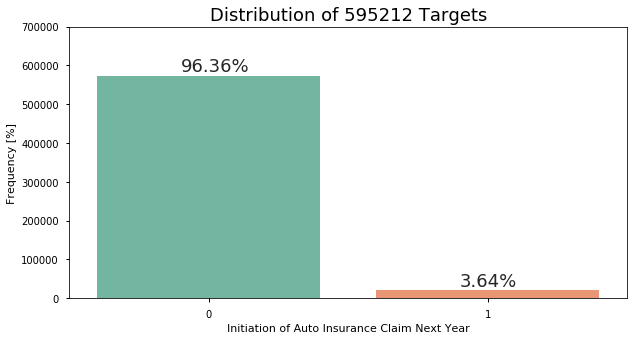

In [11]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

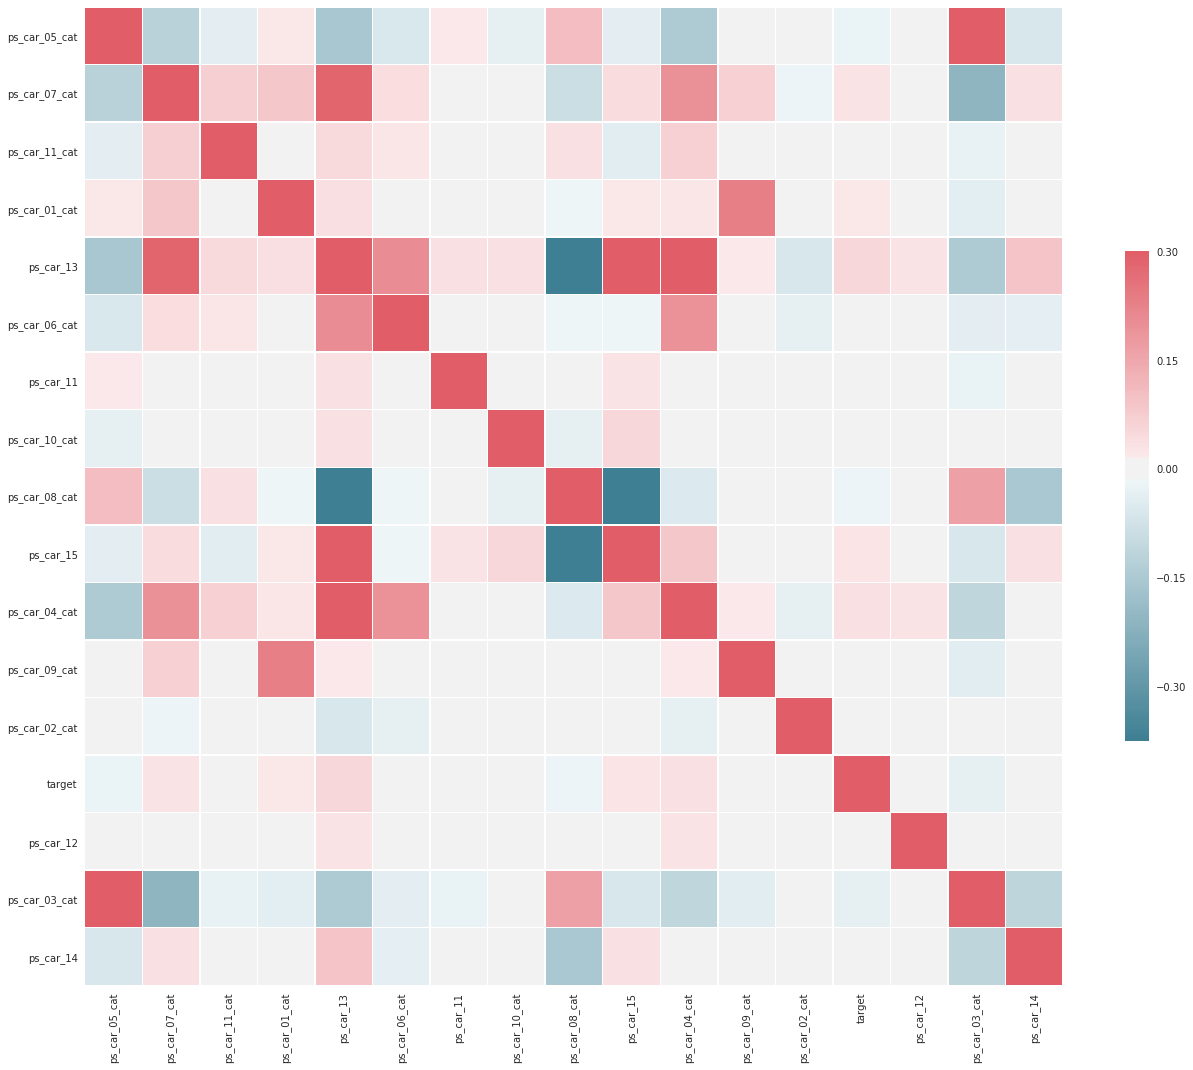

In [12]:
sns.set(style="white")


# Compute the correlation matrix
corr = train[list(set(f_dicts['label']['car'])|set(['target']))].corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

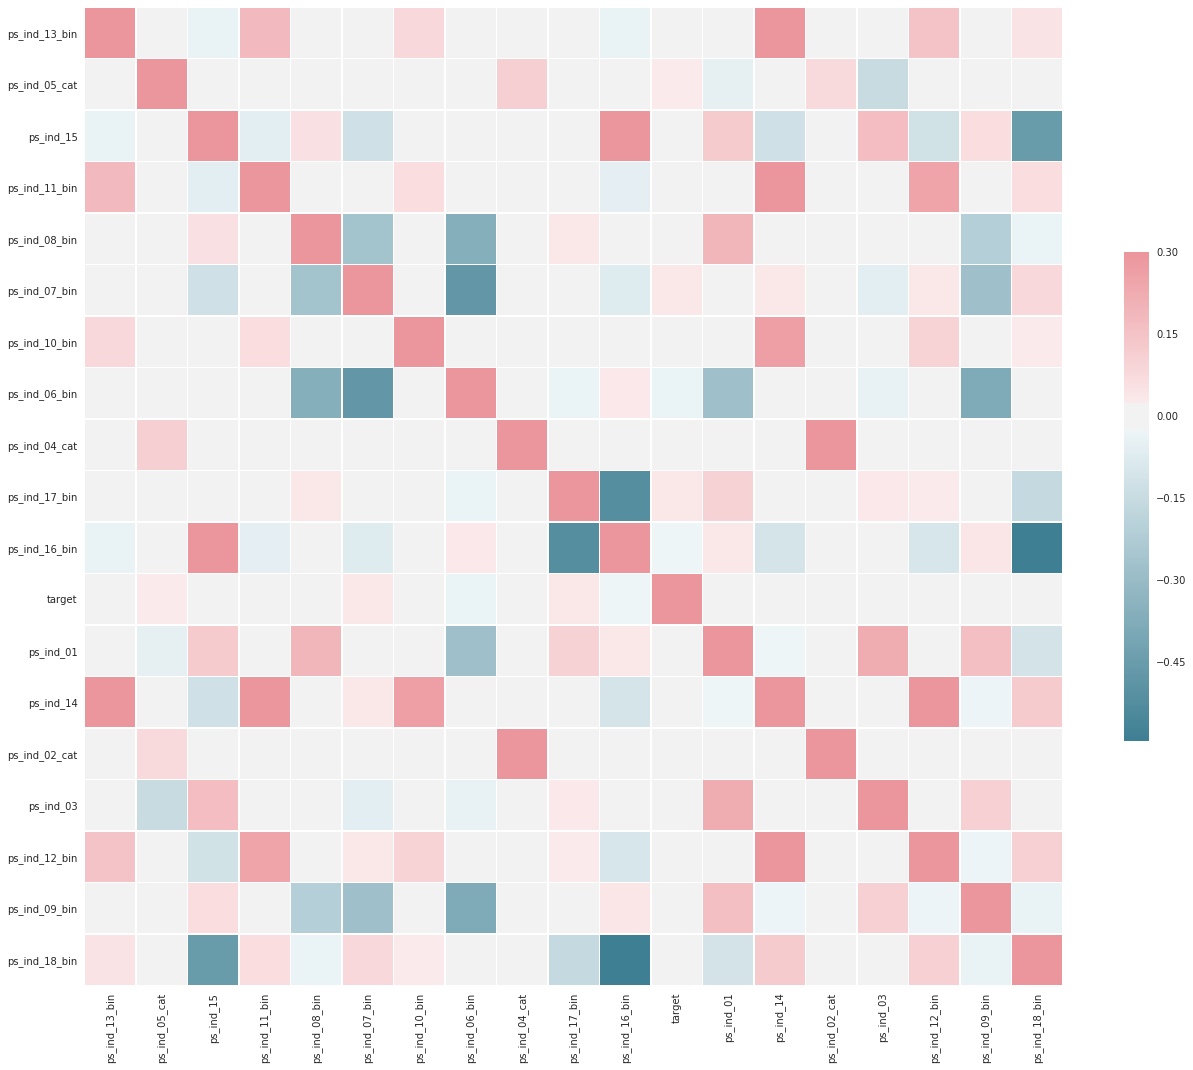

In [13]:
corr = train[list(set(f_dicts['label']['ind'])|set(['target']))].corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

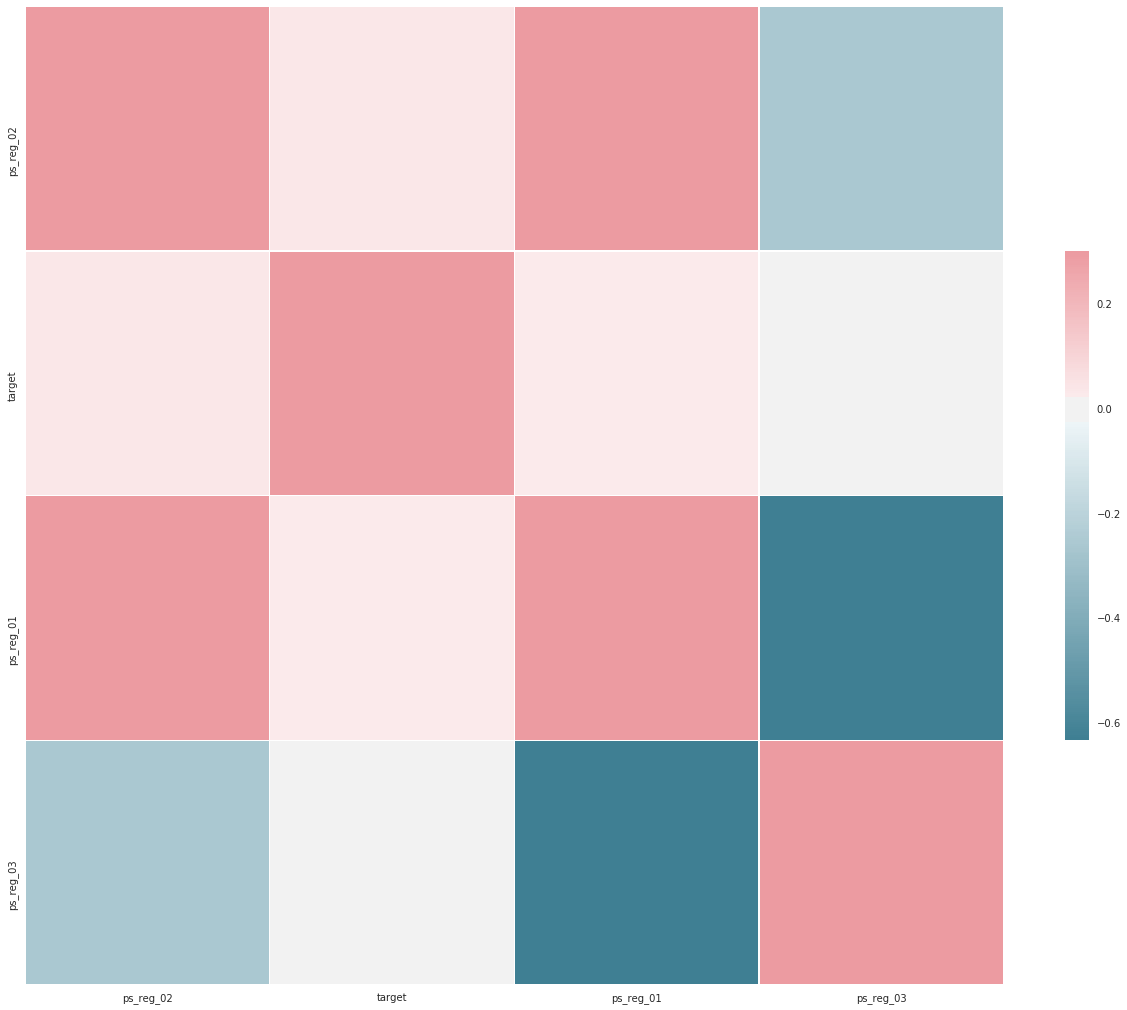

In [14]:
corr = train[list(set(f_dicts['label']['reg'])|set(['target']))].corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

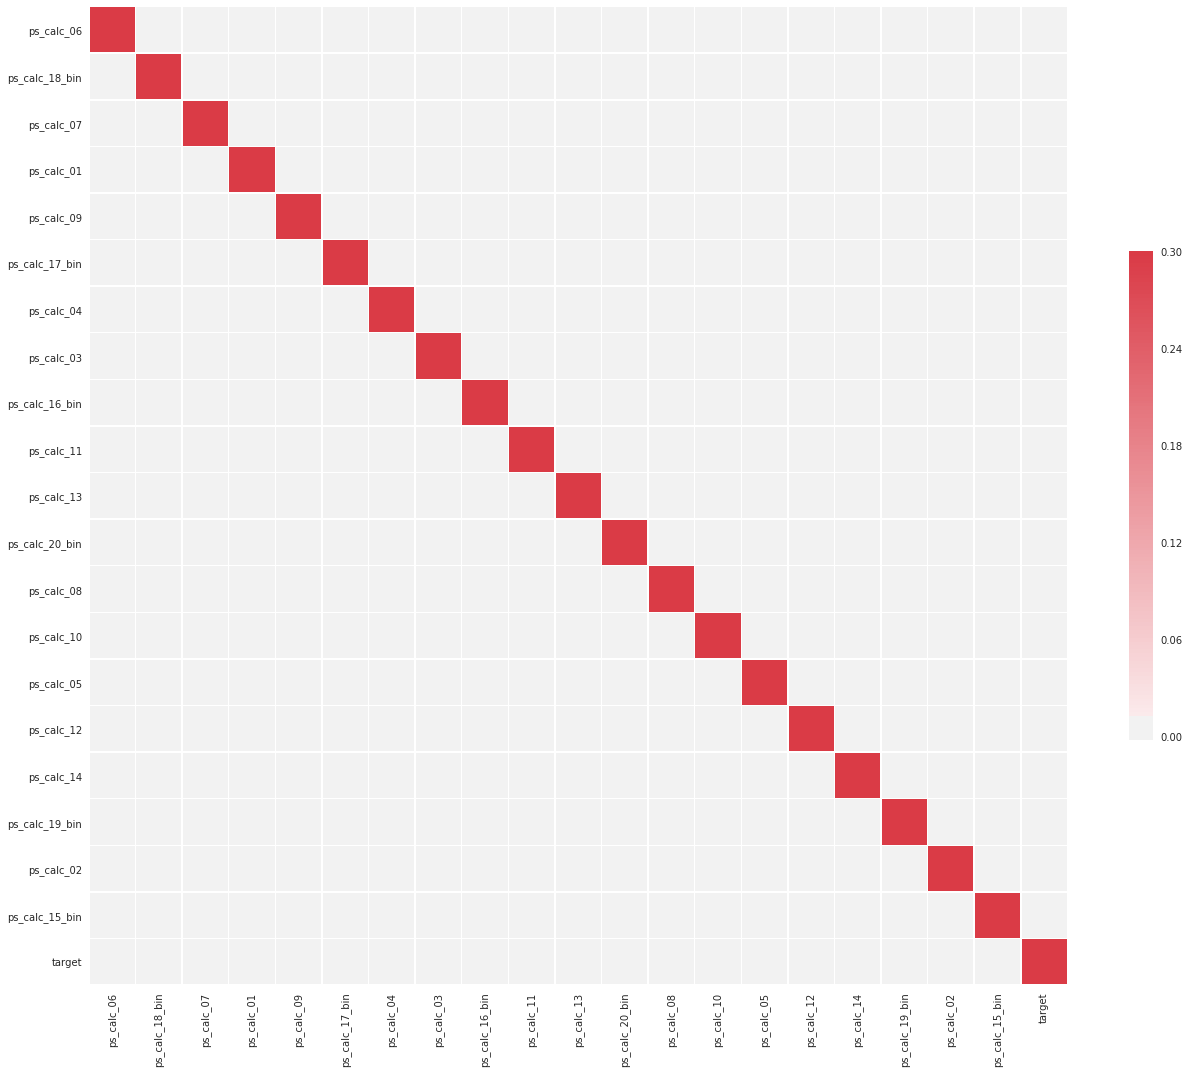

In [15]:
corr = train[list(set(f_dicts['label']['calc'])|set(['target']))].corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [16]:
old_params = {
    'min_child_weight': 11.0, # due to high class imbalance
    'objective': 'binary:logistic',
    'max_depth': 8,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.51880508157068184,
    'subsample': 0.69706874031839083,
    'eta': 0.0243024329705294538, #0.028084362074445819, #0.025
    'gamma':0.068326902334014492,
    'reg_alpha':0.00975,#0.014580176370355705,
    'num_boost_round' : 700,
    #'tree_method': 'exact',
    'tree_method': 'gpu_hist',
    #'updater': 'grow_gpu',
    'scale_pos_weight' : 2, # due to high class imbalance
    #'predictor': 'gpu_predictor'
    }

In [17]:
params = {
    'min_child_weight': 11.0, # due to high class imbalance
    'objective': 'binary:logistic',
    'max_depth': 8,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.51880508157068184,
    'subsample': 0.69706874031839083,
    'eta': 0.0243024329705294538, #0.028084362074445819, #0.025
    'gamma':0.068326902334014492,
    'reg_alpha':0.00975,#0.014580176370355705,
    'num_boost_round' : 700,
    #'tree_method': 'exact',
    'tree_method': 'gpu_hist',
    #'updater': 'grow_gpu',
    'scale_pos_weight' : 2, # due to high class imbalance
    #'predictor': 'gpu_predictor'
    }


In [19]:
X, y, X_test, test_id = prepare_data()

In [13]:
X, y, X_test, test_id = add_kmeans_features()

In [20]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

t = time.time()
best_scores = []
predictions = []

kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params,
                    d_train,
                    1600,
                    watchlist,
                    early_stopping_rounds=70,
                    feval=gini_xgb,
                    maximize=True,
                    verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold
    
    best_scores.append(np.repeat(mdl.best_score,p_test.shape[0]))
    predictions.append(p_test)
    
print()
print('this took {}seconds'.format(time.time()-t))

[Fold 1/5]


XGBoostError: b'[20:21:15] src/predictor/predictor.cc:55: Unknown predictor type gpu_predictor\n\nStack trace returned 10 entries:\n[bt] (0) /home/laith/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.so(_ZN7xgboost9Predictor6CreateENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x414) [0x7f733030cb44]\n[bt] (1) /home/laith/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.so(_ZN7xgboost3gbm6GBTree9ConfigureERKSt6vectorISt4pairINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_ESaISA_EE+0x441) [0x7f7330485691]\n[bt] (2) /home/laith/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.so(_ZN7xgboost15GradientBooster9ConfigureISt17_Rb_tree_iteratorISt4pairIKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_EEEEvT_SD_+0xfb) [0x7f73302fe6bb]\n[bt] (3) /home/laith/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.so(_ZN7xgboost11LearnerImpl13LazyInitModelEv+0x2d0) [0x7f73303073e0]\n[bt] (4) /home/laith/anaconda3/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/libxgboost.so(XGBoosterUpdateOneIter+0x3a) [0x7f7330496aea]\n[bt] (5) /home/laith/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f736c507ec0]\n[bt] (6) /home/laith/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f736c50787d]\n[bt] (7) /home/laith/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f736c71c81e]\n[bt] (8) /home/laith/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12255) [0x7f736c71d255]\n[bt] (9) /home/laith/anaconda3/bin/python(_PyObject_FastCallDict+0x8b) [0x55d73dc4935b]\n'

In [15]:
sub['target'] = np.sum(np.multiply(predictions,np.divide(best_scores,np.sum(best_scores, axis=0)[0])), axis =0)

In [16]:
filename = 'model_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/'+filename+'.csv', index=False)
np.save('../output/params_'+filename+'.npy', params)
#test = np.load('../output/params.npy').item()

In [17]:
feat_imp = pd.Series(mdl.get_fscore()).sort_values(ascending=False)
feat_imp.rename(index={i:feat_list[int(i[1:])] for i in feat_imp.index.tolist()}, inplace=True)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16,9))
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()


NameError: name 'feat_list' is not defined